<a href="https://colab.research.google.com/github/ahliminha/P300/blob/master/P300.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 install mat4py

In [0]:
import keras
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scipy.io as sio
from mat4py import loadmat 
np.random.seed(816)

Using TensorFlow backend.


In [0]:
S1 = loadmat("/content/P300S01.mat")

In [0]:
print(S1.keys())

dict_keys(['channelRange', 'Fs', 'Trials', 'stims', 'channelNames', 'sampleTime', 'samples', 'Word', 'data', 'subject'])


In [0]:
data = S1['data']

In [0]:
print(data.keys())

dict_keys(['X', 'y', 'y_stim', 'trial', 'flash'])


In [0]:
data['flash'][0]

[7486, 31, 11, 1]

In [0]:
X     = data['X']
y     = data['y']
trial = data['trial']
flash = data['flash']

In [0]:
print(trial[0:5], flash[100:105])

[7487, 17511, 27536, 37564, 47590] [[13757, 29, 10, 1], [13817, 32, 1, 1], [13881, 32, 11, 1], [13944, 32, 3, 1], [14005, 32, 12, 1]]


In [0]:
X_mean = np.mean(X, axis=1)
print(X_mean[0:5])

[ 5.66192625  9.17206368 13.73191226 17.40272486 18.14961684]


In [0]:
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [0]:
# Filter requirements.
order = 6
fs = 24.0       # sample rate, Hz
cutoff = 1.5  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Filter the data, and plot both the original and filtered signals.
X_filtered = butter_lowpass_filter(X_mean, cutoff, fs, order)

In [0]:
plt.style.use('ggplot')

In [0]:
len(X_mean)

358372

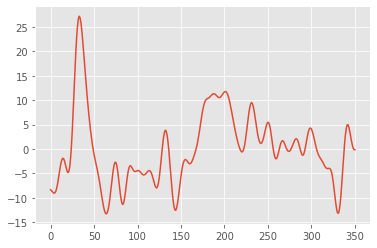

In [0]:
plt.plot(X_filtered[trial[5]:trial[5]+351])

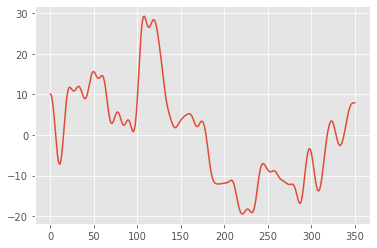

In [0]:
plt.plot(X_filtered[trial[0]:trial[0]+351])

In [0]:
X_samples = []
column = []
label = []
for i in flash:
  X_samples.append(X_filtered[i[0]:i[0]+351])
  column.append(i[2])
  label.append(i[3]-1)

In [0]:
from keras.utils import to_categorical
X_train = np.array(X_samples[:1800])
X_test  = np.array(X_samples[1800:])
y_train = np.array(to_categorical(label[:1800]))
y_test  = np.array(to_categorical(label[1800:]))
col_train = np.array(column[:1800])
col_test  = np.array(column[1800:])

In [0]:
X_train_norm = (X_train - X_train.min(axis=1, keepdims=True))/X_train.ptp(axis=1, keepdims=True)

In [0]:
def normalized(vec):
  norm_vec = (vec - vec.min(axis=1, keepdims=True))/vec.ptp(axis=1, keepdims=True)
  return norm_vec

In [0]:
X_train_norm = normalized(X_train)
X_test_norm  = normalized(X_test)


In [0]:
X_train = X_train_norm.reshape(len(X_samples[:1800]), len(X_samples[0]), 1)
X_test = X_test_norm.reshape(len(X_samples[1800:]), len(X_samples[0]), 1)


In [0]:
input_shape = X_train.shape
input_shape

(1800, 351, 1)

In [0]:
y_train.shape

(1800, 2)

In [0]:
X_train = X_train.reshape(15,120,351,1)
X_test = X_test.reshape(20,120,351,1)
y_train = y_train.reshape(15,120,2)
y_test = y_test.reshape(20,120,2)

In [0]:
y_train.shape

(15, 120, 2)

In [0]:
def Mean_Over_Flash(vector, n_cols, n_excitments):
  final_vec = []
  vec_size = vector.shape[0]
  for vec in vector:
    new_vec = vec.reshape(n_cols, n_excitments, 351, 1)
    MOF = np.mean(new_vec, 1)
    final_vec.append(MOF)
  final_vec = np.asarray(final_vec)
  return final_vec.reshape(vec_size*n_cols, 351, 1)

In [0]:
X_tr = Mean_Over_Flash(X_train, 12, 10)
X_te = Mean_Over_Flash(X_test, 12, 10)

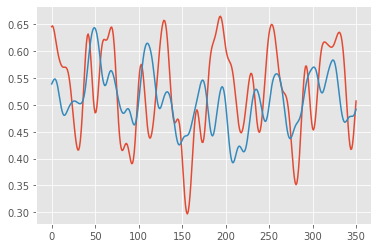

In [0]:
plt.plot(X_tr[4])
plt.plot(X_tr[0])
plt.draw()

In [0]:
X_tr.shape

(180, 351, 1)

In [0]:
def Adjust_Label_Dims(label_vec, n_excitments):
  new_label = []
  for step in label_vec:
    new_label.append(step[:12])
  new_label = np.asarray(new_label)
  return new_label.reshape(n_excitments*12, 2)

In [0]:
y_tr = Adjust_Label_Dims(y_train, 15)
y_te = Adjust_Label_Dims(y_test, 20)

In [0]:
print(X_tr.shape, y_tr.shape)

(180, 351, 1) (180, 2)


In [0]:
print(y_tr[0][0].shape)

()


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, Flatten, MaxPooling1D, GlobalAveragePooling1D

model = Sequential()
model.add(Conv1D(filters=4,
                 kernel_size=5,
                 input_shape=(351,1),
                 activation='relu',
                 padding='same',
                 strides=1))
model.add(GlobalAveragePooling1D())
model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 351, 4)            24        
_________________________________________________________________
global_average_pooling1d_1 ( (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 10        
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [0]:
#compiling the model
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_tr, y_tr, validation_data=(X_te, y_te), epochs=10, batch_size=1, verbose=1)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 180 samples, validate on 240 samples
Epoch 1/10





180/180 [==============================] - 1s 6ms/step - loss: 0.5265 - acc: 0.8333 - val_loss: 0.4729 - val_acc: 0.8333
Epoch 2/10
180/180 [==============================] - 0s 3ms/step - loss: 0.4650 - acc: 0.8333 - val_loss: 0.4527 - val_acc: 0.8333
Epoch 3/10
180/180 [==============================] - 0s 3ms/step - loss: 0.4582 - acc: 0.8333 - val_loss: 0.4506 - val_acc: 0.8333
Epoch 4/10
180/180 [==============================] - 0s 3ms/step - loss: 0.4565 - acc: 0.8333 - val_loss: 0.4505 - val_acc: 0.8333
Epoch 5/10
180/180 [==============================] - 0s 3ms/step - loss: 0.4573 - acc: 0.8333 - val_loss: 0.4501 - val_acc: 0.8333
Epoch 6/10
180/180 [==============================] - 0s 3ms/step - loss: 0.4574 - acc: 0.8333 - val_loss: 0.4501 - val_acc: 0.8333
Epoch 7/10
180/180 [==============================] - 0s 3

In [0]:
score = model.evaluate(X_te, y_te, batch_size=1, verbose=1)

240/240 [==============================] - 0s 629us/step


In [0]:
# Plot training & validation accuracy values
plt.figure(figsize=(10,10))
plt.plot(history.history['binary_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

KeyError: ignored

<Figure size 720x720 with 0 Axes>

In [0]:
# Plot training & validation loss values
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [0]:
print(score)

In [0]:
pred = model.predict(X_te)

In [0]:
for k,i in enumerate(label[1800:1805]):
  if i == 2:  
    print(k,i)

In [0]:
print(pred[:12,:])

[[0.83340925 0.16659082]
 [0.8451361  0.15486386]
 [0.84853256 0.1514675 ]
 [0.83173007 0.1682699 ]
 [0.8530711  0.1469289 ]
 [0.8512113  0.14878874]
 [0.8377869  0.16221303]
 [0.83303463 0.16696532]
 [0.8638939  0.13610606]
 [0.83126783 0.16873214]
 [0.83261764 0.16738236]
 [0.84050864 0.15949139]]


In [0]:
y_te[4]

array([0., 1.], dtype=float32)

ValueError: ignored

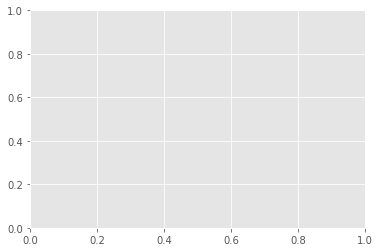

In [0]:
plt.plot(X_test[4])

In [0]:
print(np.sum(pred[4], axis=0))

In [0]:
print(np.min(pred[:,1]))

0.13493857


In [0]:
pred[:,1] -= np.min(pred[:,1])

In [0]:
from sklearn.preprocessing import normalize

new_vec = pred[:,1:]
normalized = new_vec/np.linalg.norm(new_vec)
print(normalized[:12])

[[0.07257623]
 [0.04568719]
 [0.03789959]
 [0.07642623]
 [0.02749294]
 [0.03175738]
 [0.06253827]
 [0.07343492]
 [0.00267697]
 [0.0774861 ]
 [0.07439116]
 [0.05629776]]


In [0]:
output = []
for i in pred:
  if i[2] > i[1]:
    output.append(2)
  if i[2] <= i[1]:
    output.append(1)
error = np.absolute(np.array(output)-label[1800:])
print(np.sum(error))

IndexError: ignored

In [0]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(output, label[1800:])

ValueError: ignored

In [0]:
confusion

NameError: ignored

In [0]:
import seaborn as sns
df_cm = pd.DataFrame(confusion, index = [i for i in "AB"],
                  columns = [i for i in "AB"])

df_cm_norm = df_cm/df_cm.sum(axis=1)

plt.figure(figsize = (10,7))
sns.heatmap(df_cm_norm, annot=True)

NameError: ignored

In [0]:
for k,i in enumerate(output):
  if i == 2:
    print(k,i)

In [0]:
pred_train = model.predict(X_train)

In [0]:
print(y_train[0:12])

In [0]:
pred_train[0:12]